In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import os

for dirname, _, filenames in os.walk('./inputs/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./inputs/sample_submission.csv
./inputs/test.csv
./inputs/train.csv
./inputs/training_extra.csv


Training with missing data

In [2]:
df = pd.read_csv('./inputs/training_extra.csv')
target = df["Price"]
df.drop("Price", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)
data = df
data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052
1,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095
2,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302
3,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581
4,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826
...,...,...,...,...,...,...,...,...,...
3694313,Nike,Canvas,NaN,3.0,Yes,Yes,Messenger,Blue,28.098120
3694314,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531
3694315,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708
3694316,Puma,Canvas,NaN,2.0,No,No,Backpack,Gray,28.783339


In [3]:
for i in data:
    if i != "Weight Capacity (kg)" and i != "Compartments":
        data[i] = LabelEncoder().fit_transform(data[i])

data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,4,0,2,10.0,1,1,2,1,23.882052
1,3,3,2,4.0,0,1,0,3,11.869095
2,1,3,2,8.0,1,1,2,5,8.092302
3,2,2,0,7.0,0,0,1,4,7.719581
4,2,1,0,9.0,0,1,2,3,22.741826
...,...,...,...,...,...,...,...,...,...
3694313,2,0,3,3.0,1,1,1,1,28.098120
3694314,3,1,2,10.0,1,1,2,1,17.379531
3694315,1,0,0,10.0,0,0,0,5,17.037708
3694316,3,0,3,2.0,0,0,0,2,28.783339


In [4]:
for i in data:
    if sorted(data[i].unique())[-1] < 8:
        data[i] = np.where(data[i] == sorted(data[i].unique())[-1], np.nan, data[i])

data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,4.0,0.0,2.0,10.0,1.0,1.0,2.0,1.0,23.882052
1,3.0,3.0,2.0,4.0,0.0,1.0,0.0,3.0,11.869095
2,1.0,3.0,2.0,8.0,1.0,1.0,2.0,5.0,8.092302
3,2.0,2.0,0.0,7.0,0.0,0.0,1.0,4.0,7.719581
4,2.0,1.0,0.0,9.0,0.0,1.0,2.0,3.0,22.741826
...,...,...,...,...,...,...,...,...,...
3694313,2.0,0.0,NaN,3.0,1.0,1.0,1.0,1.0,28.098120
3694314,3.0,1.0,2.0,10.0,1.0,1.0,2.0,1.0,17.379531
3694315,1.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,17.037708
3694316,3.0,0.0,NaN,2.0,0.0,0.0,0.0,2.0,28.783339


In [5]:
scaler = StandardScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data

array([[ 1.3969377 , -1.38749587,  1.26037488, ...,  1.22147526,
        -0.89497746,  0.84209503],
       [ 0.69710529,  1.28669539,  1.26037488, ..., -1.24377421,
         0.28323893, -0.88030638],
       [-0.70255954,  1.28669539,  1.26037488, ...,  1.22147526,
         1.46145532, -1.42181784],
       ...,
       [-0.70255954, -1.38749587, -1.21464582, ..., -1.24377421,
         1.46145532, -0.13923775],
       [ 0.69710529, -1.38749587,         nan, ..., -1.24377421,
        -0.30586927,  1.54483491],
       [ 1.3969377 ,  1.28669539,  0.02286453, ..., -1.24377421,
        -0.89497746,  0.72654855]])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.2, random_state=42)

In [7]:
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.load_model("./outputs/catboost_extra.model")
clf.fit(X_train, y_train, init_model=clf)
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)
clf.save_model('./outputs/catboost_extra.model')

0:	learn: 38.9262966	total: 841ms	remaining: 14m
1:	learn: 38.9249812	total: 1.47s	remaining: 12m 12s
2:	learn: 38.9237154	total: 2.02s	remaining: 11m 11s
3:	learn: 38.9224662	total: 2.47s	remaining: 10m 16s
4:	learn: 38.9212902	total: 2.99s	remaining: 9m 54s
5:	learn: 38.9201191	total: 3.44s	remaining: 9m 30s
6:	learn: 38.9189554	total: 3.93s	remaining: 9m 17s
7:	learn: 38.9178072	total: 4.41s	remaining: 9m 6s
8:	learn: 38.9166748	total: 4.86s	remaining: 8m 54s
9:	learn: 38.9155797	total: 5.24s	remaining: 8m 38s
10:	learn: 38.9145246	total: 5.69s	remaining: 8m 31s
11:	learn: 38.9134633	total: 6.19s	remaining: 8m 29s
12:	learn: 38.9124339	total: 6.66s	remaining: 8m 25s
13:	learn: 38.9113706	total: 7.09s	remaining: 8m 19s
14:	learn: 38.9103635	total: 7.53s	remaining: 8m 14s
15:	learn: 38.9093521	total: 7.96s	remaining: 8m 9s
16:	learn: 38.9083636	total: 8.37s	remaining: 8m 3s
17:	learn: 38.9074426	total: 8.78s	remaining: 7m 58s
18:	learn: 38.9065170	total: 9.17s	remaining: 7m 53s
19:	le

Training with no missing data

In [8]:
df = pd.read_csv("./modified_inputs/no_missing_training_extra.csv")
target = df["Price"]
df.drop("Price", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)
df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052
1,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095
2,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302
3,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581
4,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826
...,...,...,...,...,...,...,...,...,...
3041812,Puma,Polyester,Medium,4.0,Yes,Yes,Messenger,Pink,28.425845
3041813,Jansport,Polyester,Large,6.0,Yes,Yes,Backpack,Red,16.641739
3041814,Puma,Leather,Small,10.0,Yes,Yes,Tote,Blue,17.379531
3041815,Jansport,Canvas,Large,10.0,No,No,Backpack,Red,17.037708


In [9]:
# Encoding the data
for i in df:
    if i != "Compartments" and i != "Weight Capacity (kg)":
        df[i] = LabelEncoder().fit_transform(df[i])

df

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,4,0,2,10.0,1,1,2,1,23.882052
1,3,3,2,4.0,0,1,0,3,11.869095
2,1,3,2,8.0,1,1,2,5,8.092302
3,2,2,0,7.0,0,0,1,4,7.719581
4,2,1,0,9.0,0,1,2,3,22.741826
...,...,...,...,...,...,...,...,...,...
3041812,3,3,1,4.0,1,1,1,4,28.425845
3041813,1,3,0,6.0,1,1,0,5,16.641739
3041814,3,1,2,10.0,1,1,2,1,17.379531
3041815,1,0,0,10.0,0,0,0,5,17.037708


In [10]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(df)
scaled_data = scaler.transform(df)
scaled_data

array([[ 1.39849312, -1.38485471,  1.26040085, ...,  1.22348385,
        -0.89480795,  0.84476035],
       [ 0.69843898,  1.28942784,  1.26040085, ..., -1.24340423,
         0.28402341, -0.87921626],
       [-0.70166928,  1.28942784,  1.26040085, ...,  1.22348385,
         1.46285476, -1.42122295],
       ...,
       [ 0.69843898, -0.4934272 ,  1.26040085, ...,  1.22348385,
        -0.89480795, -0.08841493],
       [-0.70166928, -1.38485471, -1.2149164 , ..., -1.24340423,
         1.46285476, -0.13746989],
       [ 1.39849312,  1.28942784,  0.02274223, ..., -1.24340423,
        -0.89480795,  0.72910819]])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, test_size=0.2, random_state=42)

In [12]:
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.load_model('./outputs/catboost_extra.model')
clf.fit(X_train, y_train, init_model=clf)
clf.save_model("./outputs/catboost_extra.model")
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)

0:	learn: 38.7573898	total: 560ms	remaining: 9m 19s
1:	learn: 38.7573823	total: 1.03s	remaining: 8m 33s
2:	learn: 38.7573763	total: 1.45s	remaining: 8m
3:	learn: 38.7573697	total: 1.82s	remaining: 7m 34s
4:	learn: 38.7573629	total: 2.2s	remaining: 7m 18s
5:	learn: 38.7573386	total: 2.66s	remaining: 7m 21s
6:	learn: 38.7573136	total: 3.08s	remaining: 7m 17s
7:	learn: 38.7573085	total: 3.47s	remaining: 7m 9s
8:	learn: 38.7572999	total: 3.79s	remaining: 6m 57s
9:	learn: 38.7572693	total: 4.13s	remaining: 6m 48s
10:	learn: 38.7572640	total: 4.43s	remaining: 6m 38s
11:	learn: 38.7572414	total: 4.81s	remaining: 6m 35s
12:	learn: 38.7572357	total: 5.18s	remaining: 6m 33s
13:	learn: 38.7572315	total: 5.54s	remaining: 6m 29s
14:	learn: 38.7572261	total: 5.89s	remaining: 6m 26s
15:	learn: 38.7572197	total: 6.24s	remaining: 6m 23s
16:	learn: 38.7572126	total: 6.55s	remaining: 6m 18s
17:	learn: 38.7571994	total: 6.87s	remaining: 6m 15s
18:	learn: 38.7571941	total: 7.19s	remaining: 6m 11s
19:	learn

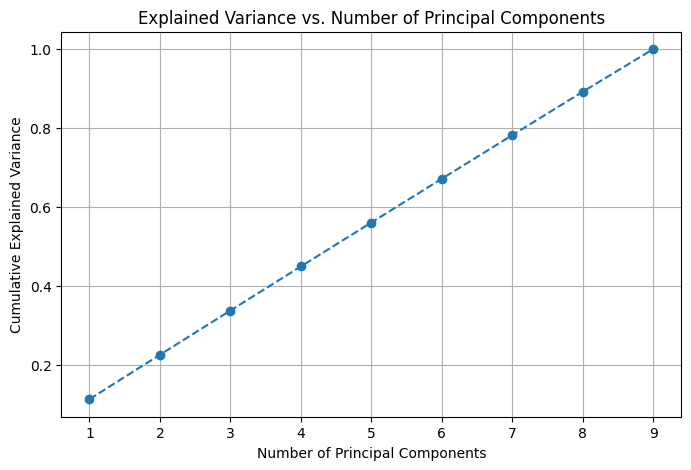

Explained Variance Ratios: [0.11430325 0.1125037  0.11183225 0.11163494 0.11100759 0.11079829
 0.11026287 0.1099252  0.10773192]
Cumulative Variance: [0.11430325 0.22680695 0.3386392  0.45027413 0.56128172 0.67208001
 0.78234288 0.89226808 1.        ]


In [13]:
# Introducing PCA
pca = PCA()
pca.fit(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Principal Components")
plt.grid()
plt.show()

# Print explained variance ratios
print("Explained Variance Ratios:", explained_variance)
print("Cumulative Variance:", cumulative_variance)

In [14]:
# Transforming data using PCA
x_pca = pca.transform(scaled_data)
X_train, X_test, y_train, y_test = train_test_split(x_pca, target, test_size=0.2, random_state=42)

In [15]:
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.load_model("./outputs/catboost_extra.model")
clf.fit(X_train, y_train, init_model=clf)
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)

0:	learn: 38.8689506	total: 518ms	remaining: 8m 37s
1:	learn: 38.8682300	total: 956ms	remaining: 7m 56s
2:	learn: 38.8675211	total: 1.39s	remaining: 7m 42s
3:	learn: 38.8668507	total: 1.85s	remaining: 7m 39s
4:	learn: 38.8661920	total: 2.31s	remaining: 7m 39s
5:	learn: 38.8655341	total: 2.83s	remaining: 7m 49s
6:	learn: 38.8648930	total: 3.66s	remaining: 8m 38s
7:	learn: 38.8642495	total: 4.43s	remaining: 9m 9s
8:	learn: 38.8635841	total: 4.84s	remaining: 8m 53s
9:	learn: 38.8629818	total: 5.29s	remaining: 8m 43s
10:	learn: 38.8623923	total: 5.71s	remaining: 8m 33s
11:	learn: 38.8618122	total: 6.17s	remaining: 8m 27s
12:	learn: 38.8612796	total: 6.63s	remaining: 8m 23s
13:	learn: 38.8607242	total: 7.04s	remaining: 8m 15s
14:	learn: 38.8602014	total: 7.45s	remaining: 8m 9s
15:	learn: 38.8596866	total: 7.92s	remaining: 8m 7s
16:	learn: 38.8591487	total: 8.32s	remaining: 8m 1s
17:	learn: 38.8586077	total: 8.81s	remaining: 8m
18:	learn: 38.8580984	total: 9.23s	remaining: 7m 56s
19:	learn: 

Predicting the normal training set

In [16]:
# Loading the dataset from training_CBC.ipynb using %store
%store -r data
data

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
0,1.0,1.0,1.0,7.0,1.0,0.0,2.0,0.0,11.611723
1,1.0,0.0,2.0,10.0,1.0,1.0,1.0,3.0,27.078537
2,4.0,1.0,2.0,2.0,1.0,0.0,1.0,5.0,16.643760
3,2.0,2.0,2.0,8.0,1.0,0.0,1.0,3.0,12.937220
4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,17.749338
...,...,...,...,...,...,...,...,...,...
299995,0.0,1.0,2.0,9.0,0.0,0.0,2.0,1.0,12.730812
299996,1.0,1.0,0.0,6.0,0.0,1.0,2.0,1.0,26.633182
299997,3.0,0.0,0.0,9.0,1.0,1.0,0.0,4.0,11.898250
299998,0.0,2.0,2.0,1.0,0.0,1.0,2.0,4.0,6.175738


In [17]:
# Loading the target data
target = pd.read_csv("./inputs/train.csv")["Price"]
target

0         112.15875
1          68.88056
2          39.17320
3          80.60793
4          86.02312
            ...    
299995    129.99749
299996     19.85819
299997    111.41364
299998    115.89080
299999     26.72762
Name: Price, Length: 300000, dtype: float64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.load_model("./outputs/catboost_extra.model")
clf.fit(X_train, y_train, init_model=clf)
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)

0:	learn: 39.2741632	total: 46.4ms	remaining: 46.4s
1:	learn: 39.2706780	total: 91.2ms	remaining: 45.5s
2:	learn: 39.2673355	total: 143ms	remaining: 47.4s
3:	learn: 39.2641475	total: 187ms	remaining: 46.6s
4:	learn: 39.2608494	total: 237ms	remaining: 47.2s
5:	learn: 39.2576166	total: 297ms	remaining: 49.2s
6:	learn: 39.2547759	total: 348ms	remaining: 49.4s
7:	learn: 39.2516621	total: 394ms	remaining: 48.9s
8:	learn: 39.2486671	total: 437ms	remaining: 48.2s
9:	learn: 39.2457313	total: 480ms	remaining: 47.5s
10:	learn: 39.2431307	total: 521ms	remaining: 46.8s
11:	learn: 39.2403036	total: 558ms	remaining: 46s
12:	learn: 39.2375229	total: 599ms	remaining: 45.5s
13:	learn: 39.2350031	total: 645ms	remaining: 45.4s
14:	learn: 39.2323179	total: 690ms	remaining: 45.3s
15:	learn: 39.2298432	total: 736ms	remaining: 45.2s
16:	learn: 39.2272078	total: 776ms	remaining: 44.9s
17:	learn: 39.2245912	total: 813ms	remaining: 44.3s
18:	learn: 39.2220263	total: 851ms	remaining: 43.9s
19:	learn: 39.2195122	

In [19]:
X_train,X_test,y_train,y_test = train_test_split(data, target, test_size=0.2, random_state=42)

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
clf = CatBoostRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42)
clf.load_model("./outputs/catboost_extra.model")
clf.fit(X_train, y_train, init_model=clf)
y_pred = clf.predict(X_test)
mean = root_mean_squared_error(y_test, y_pred)
print(mean)

0:	learn: 39.2741632	total: 236ms	remaining: 3m 55s
1:	learn: 39.2706780	total: 385ms	remaining: 3m 12s
2:	learn: 39.2673355	total: 489ms	remaining: 2m 42s
3:	learn: 39.2641475	total: 604ms	remaining: 2m 30s
4:	learn: 39.2608494	total: 673ms	remaining: 2m 13s
5:	learn: 39.2576166	total: 736ms	remaining: 2m 1s
6:	learn: 39.2547759	total: 796ms	remaining: 1m 52s
7:	learn: 39.2516621	total: 892ms	remaining: 1m 50s
8:	learn: 39.2486671	total: 973ms	remaining: 1m 47s
9:	learn: 39.2457313	total: 1.03s	remaining: 1m 41s
10:	learn: 39.2431307	total: 1.08s	remaining: 1m 37s
11:	learn: 39.2403036	total: 1.13s	remaining: 1m 33s
12:	learn: 39.2375229	total: 1.18s	remaining: 1m 29s
13:	learn: 39.2350031	total: 1.24s	remaining: 1m 26s
14:	learn: 39.2323179	total: 1.29s	remaining: 1m 24s
15:	learn: 39.2298432	total: 1.35s	remaining: 1m 22s
16:	learn: 39.2272078	total: 1.41s	remaining: 1m 21s
17:	learn: 39.2245912	total: 1.47s	remaining: 1m 20s
18:	learn: 39.2220263	total: 1.54s	remaining: 1m 19s
19:	